In [2]:
import random
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import scipy.stats as st
from scipy.spatial import KDTree
import math
from numba import njit
from numba import jit
from typing import *
from itertools import accumulate
from functools import reduce
import os
import re
import datetime
from scipy.spatial.distance import cdist
import lda
import lda.datasets

import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
def prepare_data(adata : an.AnnData, todense : bool = True, select_hvg : bool = True)-> an.AnnData:
    adata.var_names_make_unique()
    if todense:
        X = np.array(adata.X.todense())
        adata.X = X
    if select_hvg:
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, n_top_genes = 1000)
        adata = adata[:,adata.var.highly_variable.values]
        adata.X = (np.exp(adata.X) -1).round(0)
    return adata

def plot_theta_synth(adata, dt, theta, tag):
    theta = get_theta(dt)
    side_length = adata.uns["info"]["side_length"]
    plt.imshow(theta.reshape(side_length,side_length,3))
    plt.title(tag)
    plt.show()

In [4]:
path = "/Users/juliafoyer/Documents/Skolarbete/Masters_thesis/Scripts/spatial-data-synth/20210402100654897026-synth-data.h5ad"
adata = an.read_h5ad(path)
adata = prepare_data(adata, todense = False, select_hvg = False)

In [5]:
theta_df = pd.read_csv("synth2000b-theta.tsv", delimiter='\t',)
phi_df = pd.read_csv("synth2000b-phi.tsv", delimiter='\t',)

In [6]:
del phi_df['Unnamed: 0']
del theta_df['Unnamed: 0']
theta = theta_df.to_numpy()
phi = phi_df.to_numpy()

In [7]:
model = lda.LDA(n_topics=3, n_iter=1500, random_state=1)
X = np.array(adata.X, dtype='int64')
model.fit(X)

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 50
INFO:lda:n_words: 10346
INFO:lda:n_topics: 3
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log l

## Plots

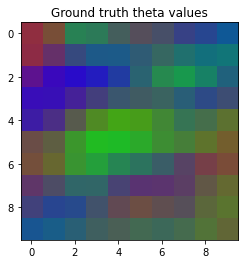

In [8]:
side_length = adata.uns["info"]["side_length"]
plt.imshow(adata.obsm["theta"].reshape(side_length,side_length,3))
plt.title("Ground truth theta values")
plt.savefig("/Users/juliafoyer/Documents/Skolarbete/Masters_thesis/Figures/ground_truth.png")

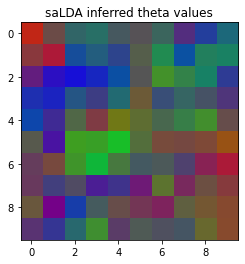

In [9]:
side_length = adata.uns["info"]["side_length"]
plt.imshow(theta.reshape(side_length,side_length,3))
plt.title("saLDA inferred theta values")
plt.savefig("/Users/juliafoyer/Documents/Skolarbete/Masters_thesis/Figures/saLDA_synth.png")

In [10]:
model_topics_ord = model.doc_topic_[:,[1,0,2]]

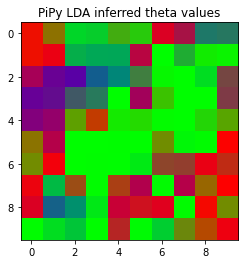

In [11]:
side_length = adata.uns["info"]["side_length"]
plt.imshow(model_topics_ord.reshape(side_length,side_length,3))
plt.title("PiPy LDA inferred theta values")
plt.savefig("/Users/juliafoyer/Documents/Skolarbete/Masters_thesis/Figures/LDA_synth.png")

## Validate model performance

In [36]:
def get_theta(dt):
    theta = dt / dt.sum(axis=1, keepdims=True)
    return theta

def get_phi(wt):
    phi = wt/wt.sum(axis=1, keepdims=True)
    return phi

def correlate_factors(phi_obs, phi_true, theta_true):
    cos_dist = cdist(phi_true, phi_obs, 'cosine')
    factor_order = cos_dist.argmin(axis=1)
    phi_obs_ord = phi_obs[factor_order, :]
    theta_obs_ord = theta_obs[:, factor_order]
    return phi_obs_ord, theta_obs_ord

def pearson(theta, theta_true_ord, K):
    pcor = np.zeros((K, 2))
    for i, t in enumerate(theta):
        pcor[i] = st.pearsonr(t, theta_true_ord[i])
    return pcor

def validate(phi, theta, adata, K):
    # align factors for true phi and theta
    phi_true = adata.varm['phi'].T
    theta_true = adata.obsm['theta']
    phi_true_ord, theta_true_ord = correlate_factors(phi, phi_true, theta_true)
    
    # align factors for commercial LDA theta
 #   phi_pipy, theta_pipy = correlate_factors(phi, model.topic_word_, model.doc_topic_)
    
    # pearson correlation
    saLDA_pc = pearson(theta.T, theta_true_ord.T, K)
#    pipy_pc = pearson(theta_pipy.T, theta_true_ord.T, K)
    
    return saLDA_pc

In [13]:
saLDA_pc, pypi_pc = validate(phi, theta, adata, model, 3)

In [14]:
saLDA_pc

array([[7.82091352e-01, 7.59037014e-22],
       [7.15401952e-01, 6.13637263e-17],
       [8.37540653e-01, 1.79673967e-27]])

In [15]:
pypi_pc

array([[6.98683752e-01, 6.36964366e-16],
       [6.19165167e-01, 6.57726814e-12],
       [7.95110705e-01, 5.21452293e-23]])

## Estimate confidence intervals for saLDA and PyPi

#### saLDA

In [16]:
theta_true = adata.obsm['theta']
K = 3
n_spots = adata.X.shape[0]
n_iter = 1000
rs = np.zeros((n_iter,K))
for it in range(n_iter):
    sample_idx = np.random.choice(n_spots,size = n_spots,replace = True)
    for k in range(K):
        theta_sample = theta[sample_idx,k]
        true_sample = theta_true[sample_idx,k]
        r,_ = st.pearsonr(theta_sample,true_sample)
        rs[it,k] = r

In [17]:
mean = rs.mean(axis=0)
ci_upper = np.quantile(rs,0.975,axis=0)
ci_lower = np.quantile(rs,0.025,axis=0)
std = np.std(rs,axis=0)

for k in range(K):
    print("CI topic {} : [{:0.3f},{:0.3f}] | Mean {:0.3f}".format(k,ci_lower[k],ci_upper[k],mean[k]))

CI topic 0 : [0.693,0.853] | Mean 0.781
CI topic 1 : [0.592,0.803] | Mean 0.711
CI topic 2 : [0.741,0.901] | Mean 0.835


#### Pipy LDA

In [18]:
phi_pypi, theta_pypi = correlate_factors(phi, model.topic_word_, model.doc_topic_)

In [19]:
K = 3
n_spots = theta.shape[0]
n_iter = 1000
rs_pypi = np.zeros((n_iter,K))
for it in range(n_iter):
    sample_idx = np.random.choice(n_spots,size = n_spots,replace = True)
    for k in range(K):
        theta_sample = theta_pypi[sample_idx,k]
        true_sample = theta_true[sample_idx,k]
        r,_ = st.pearsonr(theta_sample,true_sample)
        rs_pypi[it,k] = r

In [20]:
mean = rs_pypi.mean(axis=0)
ci_upper = np.quantile(rs_pypi,0.975,axis=0)
ci_lower = np.quantile(rs_pypi,0.025,axis=0)
std = np.std(rs_pypi,axis=0)

for k in range(K):
    print("CI topic {} : [{:0.3f},{:0.3f}] | Mean {:0.3f}".format(k,ci_lower[k],ci_upper[k],mean[k]))

CI topic 0 : [0.584,0.781] | Mean 0.695
CI topic 1 : [0.499,0.726] | Mean 0.621
CI topic 2 : [0.690,0.871] | Mean 0.793


#### Random factors

In [93]:
theta_true = adata.obsm["theta"]

In [94]:
K = 3
n_iter = 100
n_spots = adata.X.shape[0]
rs = np.zeros((n_iter,K))
for ii in range(n_iter):
    sample_theta = np.random.dirichlet(np.ones(3)*0.1,size = n_spots)
    for k in range(K):
        rs[ii,k],_ = st.pearsonr(sample_theta[:,k],theta_true[:,k])   

In [95]:
mean = rs.mean(axis=0)
ci_upper = np.quantile(rs,0.975,axis=0)
ci_lower = np.quantile(rs,0.025,axis=0)
std = np.std(rs,axis=0)

In [96]:
for k in range(K):
    print("Topic {} | std : {:0.3f} | Mean {:0.3f}".format(k,std[k],mean[k]))

Topic 0 | std : 0.115 | Mean -0.015
Topic 1 | std : 0.102 | Mean 0.007
Topic 2 | std : 0.109 | Mean -0.000


### bootstrapping for PyPi LDA

In [85]:
path = "/Users/juliafoyer/Documents/Skolarbete/Masters_thesis/Scripts/spatial-data-synth/20210402100654897026-synth-data.h5ad"
adata = an.read_h5ad(path)
adata = prepare_data(adata, todense = False, select_hvg = False)
phi_true = adata.varm['phi'].T
theta_true = adata.obsm['theta']
n_spots = adata.X.shape[0]
K = 3
n_iter = 100
rs_pypi_LDA = np.zeros((n_iter,K))
model = lda.LDA(n_topics=3, n_iter=2000, random_state=1)
for ii in range(n_iter):
    X = np.array(adata.X, dtype='int64')
    model.fit(X)
    phi_ord, theta_ord = correlate_factors(model.topic_word_, model.doc_topic_, phi_true, theta_true)
    for k in range(K):
        rs_pypi_LDA[ii,k],_ = st.pearsonr(theta_ord[:,k],theta_true[:,k])  

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 50
INFO:lda:n_words: 10346
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log l

INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log

INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<38

INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<46

INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<54

INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<62

INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<70

INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<78

INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<86

INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<94

INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<

INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
IN

INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -

INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likel

INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likel

INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likel

INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likel

INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likel

INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likelihood: -35481
INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likelihood: -35673
INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likelihood: -35660
INFO:lda:<1620> log likelihood: -36165
INFO:lda:<1630> log likelihood: -35992
INFO:lda:<1640> log likelihood: -35885
INFO:lda:<1650> log likel

INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likelihood: -35481
INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likelihood: -35673
INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likelihood: -35660
INFO:lda:<1620> log likelihood: -36165
INFO:lda:<1630> log likelihood: -35992
INFO:lda:<1640> log likelihood: -35885
INFO:lda:<1650> log likelihood: -35897
INFO:lda:<1660> log likelihood: -36070
INFO:lda:<1670> log likelihood: -35804
INFO:lda:<1680> log likelihood: -35793
INFO:lda:<1690> log likelihood: -35681
INFO:lda:<1700> log likelihood: -35796
INFO:lda:<1710> log likelihood: -35824
INFO:lda:<1720> log likelihood: -36017
INFO:lda:<1730> log likel

INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likelihood: -35481
INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likelihood: -35673
INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likelihood: -35660
INFO:lda:<1620> log likelihood: -36165
INFO:lda:<1630> log likelihood: -35992
INFO:lda:<1640> log likelihood: -35885
INFO:lda:<1650> log likelihood: -35897
INFO:lda:<1660> log likelihood: -36070
INFO:lda:<1670> log likelihood: -35804
INFO:lda:<1680> log likelihood: -35793
INFO:lda:<1690> log likelihood: -35681
INFO:lda:<1700> log likelihood: -35796
INFO:lda:<1710> log likelihood: -35824
INFO:lda:<1720> log likelihood: -36017
INFO:lda:<1730> log likelihood: -35932
INFO:lda:<1740> log likelihood: -35892
INFO:lda:<1750> log likelihood: -36170
INFO:lda:<1760> log likelihood: -36186
INFO:lda:<1770> log likelihood: -36140
INFO:lda:<1780> log likelihood: -36119
INFO:lda:<1790> log likelihood: -36097
INFO:lda:<1800> log likelihood: -36190
INFO:lda:<1810> log likel

INFO:lda:<1640> log likelihood: -35885
INFO:lda:<1650> log likelihood: -35897
INFO:lda:<1660> log likelihood: -36070
INFO:lda:<1670> log likelihood: -35804
INFO:lda:<1680> log likelihood: -35793
INFO:lda:<1690> log likelihood: -35681
INFO:lda:<1700> log likelihood: -35796
INFO:lda:<1710> log likelihood: -35824
INFO:lda:<1720> log likelihood: -36017
INFO:lda:<1730> log likelihood: -35932
INFO:lda:<1740> log likelihood: -35892
INFO:lda:<1750> log likelihood: -36170
INFO:lda:<1760> log likelihood: -36186
INFO:lda:<1770> log likelihood: -36140
INFO:lda:<1780> log likelihood: -36119
INFO:lda:<1790> log likelihood: -36097
INFO:lda:<1800> log likelihood: -36190
INFO:lda:<1810> log likelihood: -35882
INFO:lda:<1820> log likelihood: -35782
INFO:lda:<1830> log likelihood: -36072
INFO:lda:<1840> log likelihood: -36249
INFO:lda:<1850> log likelihood: -36033
INFO:lda:<1860> log likelihood: -35991
INFO:lda:<1870> log likelihood: -35996
INFO:lda:<1880> log likelihood: -35998
INFO:lda:<1890> log likel

INFO:lda:<1720> log likelihood: -36017
INFO:lda:<1730> log likelihood: -35932
INFO:lda:<1740> log likelihood: -35892
INFO:lda:<1750> log likelihood: -36170
INFO:lda:<1760> log likelihood: -36186
INFO:lda:<1770> log likelihood: -36140
INFO:lda:<1780> log likelihood: -36119
INFO:lda:<1790> log likelihood: -36097
INFO:lda:<1800> log likelihood: -36190
INFO:lda:<1810> log likelihood: -35882
INFO:lda:<1820> log likelihood: -35782
INFO:lda:<1830> log likelihood: -36072
INFO:lda:<1840> log likelihood: -36249
INFO:lda:<1850> log likelihood: -36033
INFO:lda:<1860> log likelihood: -35991
INFO:lda:<1870> log likelihood: -35996
INFO:lda:<1880> log likelihood: -35998
INFO:lda:<1890> log likelihood: -35935
INFO:lda:<1900> log likelihood: -36002
INFO:lda:<1910> log likelihood: -35785
INFO:lda:<1920> log likelihood: -35976
INFO:lda:<1930> log likelihood: -35996
INFO:lda:<1940> log likelihood: -35852
INFO:lda:<1950> log likelihood: -36100
INFO:lda:<1960> log likelihood: -36035
INFO:lda:<1970> log likel

INFO:lda:<1800> log likelihood: -36190
INFO:lda:<1810> log likelihood: -35882
INFO:lda:<1820> log likelihood: -35782
INFO:lda:<1830> log likelihood: -36072
INFO:lda:<1840> log likelihood: -36249
INFO:lda:<1850> log likelihood: -36033
INFO:lda:<1860> log likelihood: -35991
INFO:lda:<1870> log likelihood: -35996
INFO:lda:<1880> log likelihood: -35998
INFO:lda:<1890> log likelihood: -35935
INFO:lda:<1900> log likelihood: -36002
INFO:lda:<1910> log likelihood: -35785
INFO:lda:<1920> log likelihood: -35976
INFO:lda:<1930> log likelihood: -35996
INFO:lda:<1940> log likelihood: -35852
INFO:lda:<1950> log likelihood: -36100
INFO:lda:<1960> log likelihood: -36035
INFO:lda:<1970> log likelihood: -36367
INFO:lda:<1980> log likelihood: -36158
INFO:lda:<1990> log likelihood: -36173
INFO:lda:<1999> log likelihood: -36155
INFO:lda:n_documents: 100
INFO:lda:vocab_size: 50
INFO:lda:n_words: 10346
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood

INFO:lda:<1880> log likelihood: -35998
INFO:lda:<1890> log likelihood: -35935
INFO:lda:<1900> log likelihood: -36002
INFO:lda:<1910> log likelihood: -35785
INFO:lda:<1920> log likelihood: -35976
INFO:lda:<1930> log likelihood: -35996
INFO:lda:<1940> log likelihood: -35852
INFO:lda:<1950> log likelihood: -36100
INFO:lda:<1960> log likelihood: -36035
INFO:lda:<1970> log likelihood: -36367
INFO:lda:<1980> log likelihood: -36158
INFO:lda:<1990> log likelihood: -36173
INFO:lda:<1999> log likelihood: -36155
INFO:lda:n_documents: 100
INFO:lda:vocab_size: 50
INFO:lda:n_words: 10346
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:ld

INFO:lda:<1960> log likelihood: -36035
INFO:lda:<1970> log likelihood: -36367
INFO:lda:<1980> log likelihood: -36158
INFO:lda:<1990> log likelihood: -36173
INFO:lda:<1999> log likelihood: -36155
INFO:lda:n_documents: 100
INFO:lda:vocab_size: 50
INFO:lda:n_words: 10346
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> 

INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
I

INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> l

INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<40

INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<48

INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<56

INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<64

INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<72

INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<80

INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<88

INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<96

INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda

INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150


INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood:

INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likel

INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likel

INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likel

INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likel

INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likelihood: -35481
INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likel

INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likelihood: -35481
INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likelihood: -35673
INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likelihood: -35660
INFO:lda:<1620> log likelihood: -36165
INFO:lda:<1630> log likelihood: -35992
INFO:lda:<1640> log likelihood: -35885
INFO:lda:<1650> log likelihood: -35897
INFO:lda:<1660> log likelihood: -36070
INFO:lda:<1670> log likel

INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likelihood: -35481
INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likelihood: -35673
INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likelihood: -35660
INFO:lda:<1620> log likelihood: -36165
INFO:lda:<1630> log likelihood: -35992
INFO:lda:<1640> log likelihood: -35885
INFO:lda:<1650> log likelihood: -35897
INFO:lda:<1660> log likelihood: -36070
INFO:lda:<1670> log likelihood: -35804
INFO:lda:<1680> log likelihood: -35793
INFO:lda:<1690> log likelihood: -35681
INFO:lda:<1700> log likelihood: -35796
INFO:lda:<1710> log likelihood: -35824
INFO:lda:<1720> log likelihood: -36017
INFO:lda:<1730> log likelihood: -35932
INFO:lda:<1740> log likelihood: -35892
INFO:lda:<1750> log likel

INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likelihood: -35673
INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likelihood: -35660
INFO:lda:<1620> log likelihood: -36165
INFO:lda:<1630> log likelihood: -35992
INFO:lda:<1640> log likelihood: -35885
INFO:lda:<1650> log likelihood: -35897
INFO:lda:<1660> log likelihood: -36070
INFO:lda:<1670> log likelihood: -35804
INFO:lda:<1680> log likelihood: -35793
INFO:lda:<1690> log likelihood: -35681
INFO:lda:<1700> log likelihood: -35796
INFO:lda:<1710> log likelihood: -35824
INFO:lda:<1720> log likelihood: -36017
INFO:lda:<1730> log likelihood: -35932
INFO:lda:<1740> log likelihood: -35892
INFO:lda:<1750> log likelihood: -36170
INFO:lda:<1760> log likelihood: -36186
INFO:lda:<1770> log likelihood: -36140
INFO:lda:<1780> log likelihood: -36119
INFO:lda:<1790> log likelihood: -36097
INFO:lda:<1800> log likelihood: -36190
INFO:lda:<1810> log likelihood: -35882
INFO:lda:<1820> log likelihood: -35782
INFO:lda:<1830> log likel

INFO:lda:<1660> log likelihood: -36070
INFO:lda:<1670> log likelihood: -35804
INFO:lda:<1680> log likelihood: -35793
INFO:lda:<1690> log likelihood: -35681
INFO:lda:<1700> log likelihood: -35796
INFO:lda:<1710> log likelihood: -35824
INFO:lda:<1720> log likelihood: -36017
INFO:lda:<1730> log likelihood: -35932
INFO:lda:<1740> log likelihood: -35892
INFO:lda:<1750> log likelihood: -36170
INFO:lda:<1760> log likelihood: -36186
INFO:lda:<1770> log likelihood: -36140
INFO:lda:<1780> log likelihood: -36119
INFO:lda:<1790> log likelihood: -36097
INFO:lda:<1800> log likelihood: -36190
INFO:lda:<1810> log likelihood: -35882
INFO:lda:<1820> log likelihood: -35782
INFO:lda:<1830> log likelihood: -36072
INFO:lda:<1840> log likelihood: -36249
INFO:lda:<1850> log likelihood: -36033
INFO:lda:<1860> log likelihood: -35991
INFO:lda:<1870> log likelihood: -35996
INFO:lda:<1880> log likelihood: -35998
INFO:lda:<1890> log likelihood: -35935
INFO:lda:<1900> log likelihood: -36002
INFO:lda:<1910> log likel

INFO:lda:<1740> log likelihood: -35892
INFO:lda:<1750> log likelihood: -36170
INFO:lda:<1760> log likelihood: -36186
INFO:lda:<1770> log likelihood: -36140
INFO:lda:<1780> log likelihood: -36119
INFO:lda:<1790> log likelihood: -36097
INFO:lda:<1800> log likelihood: -36190
INFO:lda:<1810> log likelihood: -35882
INFO:lda:<1820> log likelihood: -35782
INFO:lda:<1830> log likelihood: -36072
INFO:lda:<1840> log likelihood: -36249
INFO:lda:<1850> log likelihood: -36033
INFO:lda:<1860> log likelihood: -35991
INFO:lda:<1870> log likelihood: -35996
INFO:lda:<1880> log likelihood: -35998
INFO:lda:<1890> log likelihood: -35935
INFO:lda:<1900> log likelihood: -36002
INFO:lda:<1910> log likelihood: -35785
INFO:lda:<1920> log likelihood: -35976
INFO:lda:<1930> log likelihood: -35996
INFO:lda:<1940> log likelihood: -35852
INFO:lda:<1950> log likelihood: -36100
INFO:lda:<1960> log likelihood: -36035
INFO:lda:<1970> log likelihood: -36367
INFO:lda:<1980> log likelihood: -36158
INFO:lda:<1990> log likel

INFO:lda:<1820> log likelihood: -35782
INFO:lda:<1830> log likelihood: -36072
INFO:lda:<1840> log likelihood: -36249
INFO:lda:<1850> log likelihood: -36033
INFO:lda:<1860> log likelihood: -35991
INFO:lda:<1870> log likelihood: -35996
INFO:lda:<1880> log likelihood: -35998
INFO:lda:<1890> log likelihood: -35935
INFO:lda:<1900> log likelihood: -36002
INFO:lda:<1910> log likelihood: -35785
INFO:lda:<1920> log likelihood: -35976
INFO:lda:<1930> log likelihood: -35996
INFO:lda:<1940> log likelihood: -35852
INFO:lda:<1950> log likelihood: -36100
INFO:lda:<1960> log likelihood: -36035
INFO:lda:<1970> log likelihood: -36367
INFO:lda:<1980> log likelihood: -36158
INFO:lda:<1990> log likelihood: -36173
INFO:lda:<1999> log likelihood: -36155
INFO:lda:n_documents: 100
INFO:lda:vocab_size: 50
INFO:lda:n_words: 10346
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -3

INFO:lda:<1900> log likelihood: -36002
INFO:lda:<1910> log likelihood: -35785
INFO:lda:<1920> log likelihood: -35976
INFO:lda:<1930> log likelihood: -35996
INFO:lda:<1940> log likelihood: -35852
INFO:lda:<1950> log likelihood: -36100
INFO:lda:<1960> log likelihood: -36035
INFO:lda:<1970> log likelihood: -36367
INFO:lda:<1980> log likelihood: -36158
INFO:lda:<1990> log likelihood: -36173
INFO:lda:<1999> log likelihood: -36155
INFO:lda:n_documents: 100
INFO:lda:vocab_size: 50
INFO:lda:n_words: 10346
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:

INFO:lda:<1980> log likelihood: -36158
INFO:lda:<1990> log likelihood: -36173
INFO:lda:<1999> log likelihood: -36155
INFO:lda:n_documents: 100
INFO:lda:vocab_size: 50
INFO:lda:n_words: 10346
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> lo

INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log like

INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340>

INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<42

INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<50

INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<58

INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<66

INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<74

INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<82

INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<90

INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<98

INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:l

INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -3602

INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihoo

INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likel

INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likel

INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likel

INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likel

INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likelihood: -35481
INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likelihood: -35673
INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likel

INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likelihood: -35481
INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likelihood: -35673
INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likelihood: -35660
INFO:lda:<1620> log likelihood: -36165
INFO:lda:<1630> log likelihood: -35992
INFO:lda:<1640> log likelihood: -35885
INFO:lda:<1650> log likelihood: -35897
INFO:lda:<1660> log likelihood: -36070
INFO:lda:<1670> log likelihood: -35804
INFO:lda:<1680> log likelihood: -35793
INFO:lda:<1690> log likel

INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likelihood: -35481
INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likelihood: -35673
INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likelihood: -35660
INFO:lda:<1620> log likelihood: -36165
INFO:lda:<1630> log likelihood: -35992
INFO:lda:<1640> log likelihood: -35885
INFO:lda:<1650> log likelihood: -35897
INFO:lda:<1660> log likelihood: -36070
INFO:lda:<1670> log likelihood: -35804
INFO:lda:<1680> log likelihood: -35793
INFO:lda:<1690> log likelihood: -35681
INFO:lda:<1700> log likelihood: -35796
INFO:lda:<1710> log likelihood: -35824
INFO:lda:<1720> log likelihood: -36017
INFO:lda:<1730> log likelihood: -35932
INFO:lda:<1740> log likelihood: -35892
INFO:lda:<1750> log likelihood: -36170
INFO:lda:<1760> log likelihood: -36186
INFO:lda:<1770> log likel

INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likelihood: -35660
INFO:lda:<1620> log likelihood: -36165
INFO:lda:<1630> log likelihood: -35992
INFO:lda:<1640> log likelihood: -35885
INFO:lda:<1650> log likelihood: -35897
INFO:lda:<1660> log likelihood: -36070
INFO:lda:<1670> log likelihood: -35804
INFO:lda:<1680> log likelihood: -35793
INFO:lda:<1690> log likelihood: -35681
INFO:lda:<1700> log likelihood: -35796
INFO:lda:<1710> log likelihood: -35824
INFO:lda:<1720> log likelihood: -36017
INFO:lda:<1730> log likelihood: -35932
INFO:lda:<1740> log likelihood: -35892
INFO:lda:<1750> log likelihood: -36170
INFO:lda:<1760> log likelihood: -36186
INFO:lda:<1770> log likelihood: -36140
INFO:lda:<1780> log likelihood: -36119
INFO:lda:<1790> log likelihood: -36097
INFO:lda:<1800> log likelihood: -36190
INFO:lda:<1810> log likelihood: -35882
INFO:lda:<1820> log likelihood: -35782
INFO:lda:<1830> log likelihood: -36072
INFO:lda:<1840> log likelihood: -36249
INFO:lda:<1850> log likel

INFO:lda:<1680> log likelihood: -35793
INFO:lda:<1690> log likelihood: -35681
INFO:lda:<1700> log likelihood: -35796
INFO:lda:<1710> log likelihood: -35824
INFO:lda:<1720> log likelihood: -36017
INFO:lda:<1730> log likelihood: -35932
INFO:lda:<1740> log likelihood: -35892
INFO:lda:<1750> log likelihood: -36170
INFO:lda:<1760> log likelihood: -36186
INFO:lda:<1770> log likelihood: -36140
INFO:lda:<1780> log likelihood: -36119
INFO:lda:<1790> log likelihood: -36097
INFO:lda:<1800> log likelihood: -36190
INFO:lda:<1810> log likelihood: -35882
INFO:lda:<1820> log likelihood: -35782
INFO:lda:<1830> log likelihood: -36072
INFO:lda:<1840> log likelihood: -36249
INFO:lda:<1850> log likelihood: -36033
INFO:lda:<1860> log likelihood: -35991
INFO:lda:<1870> log likelihood: -35996
INFO:lda:<1880> log likelihood: -35998
INFO:lda:<1890> log likelihood: -35935
INFO:lda:<1900> log likelihood: -36002
INFO:lda:<1910> log likelihood: -35785
INFO:lda:<1920> log likelihood: -35976
INFO:lda:<1930> log likel

INFO:lda:<1760> log likelihood: -36186
INFO:lda:<1770> log likelihood: -36140
INFO:lda:<1780> log likelihood: -36119
INFO:lda:<1790> log likelihood: -36097
INFO:lda:<1800> log likelihood: -36190
INFO:lda:<1810> log likelihood: -35882
INFO:lda:<1820> log likelihood: -35782
INFO:lda:<1830> log likelihood: -36072
INFO:lda:<1840> log likelihood: -36249
INFO:lda:<1850> log likelihood: -36033
INFO:lda:<1860> log likelihood: -35991
INFO:lda:<1870> log likelihood: -35996
INFO:lda:<1880> log likelihood: -35998
INFO:lda:<1890> log likelihood: -35935
INFO:lda:<1900> log likelihood: -36002
INFO:lda:<1910> log likelihood: -35785
INFO:lda:<1920> log likelihood: -35976
INFO:lda:<1930> log likelihood: -35996
INFO:lda:<1940> log likelihood: -35852
INFO:lda:<1950> log likelihood: -36100
INFO:lda:<1960> log likelihood: -36035
INFO:lda:<1970> log likelihood: -36367
INFO:lda:<1980> log likelihood: -36158
INFO:lda:<1990> log likelihood: -36173
INFO:lda:<1999> log likelihood: -36155
INFO:lda:n_documents: 100

INFO:lda:<1840> log likelihood: -36249
INFO:lda:<1850> log likelihood: -36033
INFO:lda:<1860> log likelihood: -35991
INFO:lda:<1870> log likelihood: -35996
INFO:lda:<1880> log likelihood: -35998
INFO:lda:<1890> log likelihood: -35935
INFO:lda:<1900> log likelihood: -36002
INFO:lda:<1910> log likelihood: -35785
INFO:lda:<1920> log likelihood: -35976
INFO:lda:<1930> log likelihood: -35996
INFO:lda:<1940> log likelihood: -35852
INFO:lda:<1950> log likelihood: -36100
INFO:lda:<1960> log likelihood: -36035
INFO:lda:<1970> log likelihood: -36367
INFO:lda:<1980> log likelihood: -36158
INFO:lda:<1990> log likelihood: -36173
INFO:lda:<1999> log likelihood: -36155
INFO:lda:n_documents: 100
INFO:lda:vocab_size: 50
INFO:lda:n_words: 10346
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325

INFO:lda:<1920> log likelihood: -35976
INFO:lda:<1930> log likelihood: -35996
INFO:lda:<1940> log likelihood: -35852
INFO:lda:<1950> log likelihood: -36100
INFO:lda:<1960> log likelihood: -36035
INFO:lda:<1970> log likelihood: -36367
INFO:lda:<1980> log likelihood: -36158
INFO:lda:<1990> log likelihood: -36173
INFO:lda:<1999> log likelihood: -36155
INFO:lda:n_documents: 100
INFO:lda:vocab_size: 50
INFO:lda:n_words: 10346
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<1

INFO:lda:<1999> log likelihood: -36155
INFO:lda:n_documents: 100
INFO:lda:vocab_size: 50
INFO:lda:n_words: 10346
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -44331
INFO:lda:<10> log likelihood: -39607
INFO:lda:<20> log likelihood: -38624
INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log 

INFO:lda:<30> log likelihood: -37909
INFO:lda:<40> log likelihood: -37618
INFO:lda:<50> log likelihood: -37325
INFO:lda:<60> log likelihood: -37367
INFO:lda:<70> log likelihood: -37579
INFO:lda:<80> log likelihood: -37177
INFO:lda:<90> log likelihood: -36957
INFO:lda:<100> log likelihood: -36764
INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log 

INFO:lda:<110> log likelihood: -36485
INFO:lda:<120> log likelihood: -36632
INFO:lda:<130> log likelihood: -36647
INFO:lda:<140> log likelihood: -36862
INFO:lda:<150> log likelihood: -36498
INFO:lda:<160> log likelihood: -36680
INFO:lda:<170> log likelihood: -36434
INFO:lda:<180> log likelihood: -36423
INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<37

INFO:lda:<190> log likelihood: -35910
INFO:lda:<200> log likelihood: -36185
INFO:lda:<210> log likelihood: -36374
INFO:lda:<220> log likelihood: -36226
INFO:lda:<230> log likelihood: -36174
INFO:lda:<240> log likelihood: -35654
INFO:lda:<250> log likelihood: -35769
INFO:lda:<260> log likelihood: -35668
INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<45

INFO:lda:<270> log likelihood: -35319
INFO:lda:<280> log likelihood: -35604
INFO:lda:<290> log likelihood: -35692
INFO:lda:<300> log likelihood: -35668
INFO:lda:<310> log likelihood: -35560
INFO:lda:<320> log likelihood: -35774
INFO:lda:<330> log likelihood: -36054
INFO:lda:<340> log likelihood: -35652
INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<53

INFO:lda:<350> log likelihood: -35683
INFO:lda:<360> log likelihood: -35708
INFO:lda:<370> log likelihood: -35681
INFO:lda:<380> log likelihood: -35499
INFO:lda:<390> log likelihood: -35695
INFO:lda:<400> log likelihood: -35973
INFO:lda:<410> log likelihood: -35891
INFO:lda:<420> log likelihood: -35986
INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<61

INFO:lda:<430> log likelihood: -36170
INFO:lda:<440> log likelihood: -36459
INFO:lda:<450> log likelihood: -36314
INFO:lda:<460> log likelihood: -36217
INFO:lda:<470> log likelihood: -36229
INFO:lda:<480> log likelihood: -36093
INFO:lda:<490> log likelihood: -35943
INFO:lda:<500> log likelihood: -35920
INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<69

INFO:lda:<510> log likelihood: -35796
INFO:lda:<520> log likelihood: -35994
INFO:lda:<530> log likelihood: -35986
INFO:lda:<540> log likelihood: -35732
INFO:lda:<550> log likelihood: -35593
INFO:lda:<560> log likelihood: -35664
INFO:lda:<570> log likelihood: -35649
INFO:lda:<580> log likelihood: -35640
INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<77

INFO:lda:<590> log likelihood: -35546
INFO:lda:<600> log likelihood: -35397
INFO:lda:<610> log likelihood: -35536
INFO:lda:<620> log likelihood: -35644
INFO:lda:<630> log likelihood: -35455
INFO:lda:<640> log likelihood: -35589
INFO:lda:<650> log likelihood: -35401
INFO:lda:<660> log likelihood: -35580
INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<85

INFO:lda:<670> log likelihood: -35772
INFO:lda:<680> log likelihood: -35905
INFO:lda:<690> log likelihood: -35824
INFO:lda:<700> log likelihood: -36187
INFO:lda:<710> log likelihood: -36028
INFO:lda:<720> log likelihood: -36009
INFO:lda:<730> log likelihood: -35755
INFO:lda:<740> log likelihood: -36050
INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<93

INFO:lda:<750> log likelihood: -36153
INFO:lda:<760> log likelihood: -35861
INFO:lda:<770> log likelihood: -35667
INFO:lda:<780> log likelihood: -35857
INFO:lda:<790> log likelihood: -35624
INFO:lda:<800> log likelihood: -35887
INFO:lda:<810> log likelihood: -35685
INFO:lda:<820> log likelihood: -35621
INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1

INFO:lda:<830> log likelihood: -35929
INFO:lda:<840> log likelihood: -35842
INFO:lda:<850> log likelihood: -35591
INFO:lda:<860> log likelihood: -35709
INFO:lda:<870> log likelihood: -35597
INFO:lda:<880> log likelihood: -35706
INFO:lda:<890> log likelihood: -35385
INFO:lda:<900> log likelihood: -35420
INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INF

INFO:lda:<910> log likelihood: -35761
INFO:lda:<920> log likelihood: -35840
INFO:lda:<930> log likelihood: -35805
INFO:lda:<940> log likelihood: -35773
INFO:lda:<950> log likelihood: -35894
INFO:lda:<960> log likelihood: -35882
INFO:lda:<970> log likelihood: -35608
INFO:lda:<980> log likelihood: -35654
INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -3

INFO:lda:<990> log likelihood: -35702
INFO:lda:<1000> log likelihood: -35502
INFO:lda:<1010> log likelihood: -35252
INFO:lda:<1020> log likelihood: -35205
INFO:lda:<1030> log likelihood: -35518
INFO:lda:<1040> log likelihood: -35418
INFO:lda:<1050> log likelihood: -35373
INFO:lda:<1060> log likelihood: -35539
INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likeli

INFO:lda:<1070> log likelihood: -35573
INFO:lda:<1080> log likelihood: -35536
INFO:lda:<1090> log likelihood: -35913
INFO:lda:<1100> log likelihood: -35876
INFO:lda:<1110> log likelihood: -36150
INFO:lda:<1120> log likelihood: -36118
INFO:lda:<1130> log likelihood: -36027
INFO:lda:<1140> log likelihood: -35691
INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likel

INFO:lda:<1150> log likelihood: -35517
INFO:lda:<1160> log likelihood: -35621
INFO:lda:<1170> log likelihood: -35783
INFO:lda:<1180> log likelihood: -35683
INFO:lda:<1190> log likelihood: -35848
INFO:lda:<1200> log likelihood: -35781
INFO:lda:<1210> log likelihood: -35836
INFO:lda:<1220> log likelihood: -35758
INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likel

INFO:lda:<1230> log likelihood: -35892
INFO:lda:<1240> log likelihood: -35824
INFO:lda:<1250> log likelihood: -35708
INFO:lda:<1260> log likelihood: -35397
INFO:lda:<1270> log likelihood: -35461
INFO:lda:<1280> log likelihood: -35454
INFO:lda:<1290> log likelihood: -35197
INFO:lda:<1300> log likelihood: -35347
INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likel

INFO:lda:<1310> log likelihood: -35411
INFO:lda:<1320> log likelihood: -35766
INFO:lda:<1330> log likelihood: -35969
INFO:lda:<1340> log likelihood: -36006
INFO:lda:<1350> log likelihood: -36019
INFO:lda:<1360> log likelihood: -35998
INFO:lda:<1370> log likelihood: -36100
INFO:lda:<1380> log likelihood: -36003
INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likel

INFO:lda:<1390> log likelihood: -36071
INFO:lda:<1400> log likelihood: -35995
INFO:lda:<1410> log likelihood: -35986
INFO:lda:<1420> log likelihood: -36226
INFO:lda:<1430> log likelihood: -36277
INFO:lda:<1440> log likelihood: -36225
INFO:lda:<1450> log likelihood: -36092
INFO:lda:<1460> log likelihood: -35864
INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likelihood: -35481
INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likelihood: -35673
INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likelihood: -35660
INFO:lda:<1620> log likelihood: -36165
INFO:lda:<1630> log likelihood: -35992
INFO:lda:<1640> log likel

INFO:lda:<1470> log likelihood: -36155
INFO:lda:<1480> log likelihood: -35840
INFO:lda:<1490> log likelihood: -35564
INFO:lda:<1500> log likelihood: -35814
INFO:lda:<1510> log likelihood: -35445
INFO:lda:<1520> log likelihood: -35398
INFO:lda:<1530> log likelihood: -35623
INFO:lda:<1540> log likelihood: -35816
INFO:lda:<1550> log likelihood: -35831
INFO:lda:<1560> log likelihood: -35689
INFO:lda:<1570> log likelihood: -35481
INFO:lda:<1580> log likelihood: -35500
INFO:lda:<1590> log likelihood: -35673
INFO:lda:<1600> log likelihood: -35755
INFO:lda:<1610> log likelihood: -35660
INFO:lda:<1620> log likelihood: -36165
INFO:lda:<1630> log likelihood: -35992
INFO:lda:<1640> log likelihood: -35885
INFO:lda:<1650> log likelihood: -35897
INFO:lda:<1660> log likelihood: -36070
INFO:lda:<1670> log likelihood: -35804
INFO:lda:<1680> log likelihood: -35793
INFO:lda:<1690> log likelihood: -35681
INFO:lda:<1700> log likelihood: -35796
INFO:lda:<1710> log likelihood: -35824
INFO:lda:<1720> log likel

In [87]:
mean = rs_pypi_LDA.mean(axis=0)
ci_upper = np.quantile(rs_pypi_LDA,0.975,axis=0)
ci_lower = np.quantile(rs_pypi_LDA,0.025,axis=0)
std = np.std(rs_pypi_LDA,axis=0)

In [92]:
for k in range(K):
    print("Topic {} | std : {} | Mean {:0.3f}".format(k,std[k],mean[k]))

Topic 0 | std : 2.220446049250313e-16 | Mean 0.679
Topic 1 | std : 7.771561172376096e-16 | Mean 0.596
Topic 2 | std : 3.3306690738754696e-16 | Mean 0.785


### bootstrapping for saLDA

In [76]:
def correlate_factors(phi_obs, theta_obs, phi_true, theta_true):
    cos_dist = cdist(phi_true, phi_obs, 'cosine')
    factor_order = cos_dist.argmin(axis=1)
    phi_obs_ord = phi_obs[factor_order, :]
    theta_obs_ord = theta_obs[:, factor_order]
    return phi_obs_ord, theta_obs_ord

In [54]:
K = 3
n_iter = 100
n_spots = adata.X.shape[0]
rs_saLDA_5 = np.zeros((n_iter,K))
phi_true = adata.varm['phi'].T
theta_true = adata.obsm['theta']
for ii in range(n_iter):
    ! python3 LDA_MH_implemented.py -p /Users/juliafoyer/Documents/Skolarbete/Masters_thesis/Scripts/spatial-data-synth/20210402100654897026-synth-data.h5ad -df synth -it 2000 -t "bootstrap" -w 5 -n 4
    theta_df = pd.read_csv("bootstrap-theta.tsv", delimiter='\t',)
    del theta_df['Unnamed: 0']
    phi_df = pd.read_csv("bootstrap-phi.tsv", delimiter='\t',)
    del phi_df['Unnamed: 0']
    theta = theta_df.to_numpy()
    phi = phi_df.to_numpy()
    phi_ord, theta_ord = correlate_factors(phi, theta, phi_true, theta_true)
    for k in range(K):
        rs_saLDA_5[ii,k],_ = st.pearsonr(theta_ord[:,k],theta_true[:,k])  

100%|███████████████████████████████████████| 2000/2000 [05:15<00:00,  6.33it/s]
Finished in 5.3 minutes
100%|███████████████████████████████████████| 2000/2000 [05:32<00:00,  6.01it/s]
Finished in 5.6 minutes
100%|███████████████████████████████████████| 2000/2000 [05:20<00:00,  6.23it/s]
Finished in 5.4 minutes
100%|███████████████████████████████████████| 2000/2000 [05:17<00:00,  6.29it/s]
Finished in 5.3 minutes
100%|███████████████████████████████████████| 2000/2000 [05:23<00:00,  6.19it/s]
Finished in 5.4 minutes
100%|███████████████████████████████████████| 2000/2000 [05:40<00:00,  5.87it/s]
Finished in 5.7 minutes
100%|███████████████████████████████████████| 2000/2000 [05:40<00:00,  5.87it/s]
Finished in 5.7 minutes
100%|███████████████████████████████████████| 2000/2000 [05:59<00:00,  5.57it/s]
Finished in 6.0 minutes
100%|███████████████████████████████████████| 2000/2000 [05:27<00:00,  6.10it/s]
Finished in 5.5 minutes
100%|███████████████████████████████████████| 2000/2000

100%|███████████████████████████████████████| 2000/2000 [05:18<00:00,  6.29it/s]
Finished in 5.3 minutes
100%|███████████████████████████████████████| 2000/2000 [05:18<00:00,  6.28it/s]
Finished in 5.3 minutes
100%|███████████████████████████████████████| 2000/2000 [05:18<00:00,  6.28it/s]
Finished in 5.3 minutes
100%|███████████████████████████████████████| 2000/2000 [05:25<00:00,  6.14it/s]
Finished in 5.5 minutes
libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi.dylib: terminating with uncaught exception of type std::runtime_e

In [55]:
mean = rs_saLDA.mean(axis=0)
ci_upper = np.quantile(rs_saLDA,0.975,axis=0)
ci_lower = np.quantile(rs_saLDA,0.025,axis=0)
std = np.std(rs_saLDA,axis=0)

In [56]:
for k in range(K):
    print("Topic {} | std : {:0.3f} | Mean {:0.3f}".format(k,std[k],mean[k]))

Topic 0 | std : 0.039 | Mean 0.804
Topic 1 | std : 0.035 | Mean 0.782
Topic 2 | std : 0.022 | Mean 0.849


### 300 it

In [46]:
rs_saLDA

array([[0.71387016, 0.67628869, 0.78130042],
       [0.75630178, 0.72931566, 0.83625345],
       [0.7710587 , 0.76059618, 0.75743703],
       [0.75921694, 0.78869504, 0.80812243],
       [0.79279716, 0.73469981, 0.8100357 ]])

#### 2000 it

In [50]:
rs_saLDA

array([[0.75966365, 0.72843796, 0.81690726],
       [0.77581443, 0.71735491, 0.83003122],
       [0.82282128, 0.79805666, 0.85877387]])

### 2000 it, w 10

In [52]:
rs_saLDA

array([[0.85470935, 0.81537548, 0.89854045],
       [0.83652995, 0.77576763, 0.86198484],
       [0.8083976 , 0.82954027, 0.85492729]])